# Digital Twin–Based IoT System  
## Simulation Initialization (Assignment 4)

### 1. Night-Time Physiological Data Simulation
This section simulates heart rate and SpO₂ signals for an 8-hour night monitoring session.

### 2. Signal Visualization
The simulated signals are visualized to represent the initial system model.


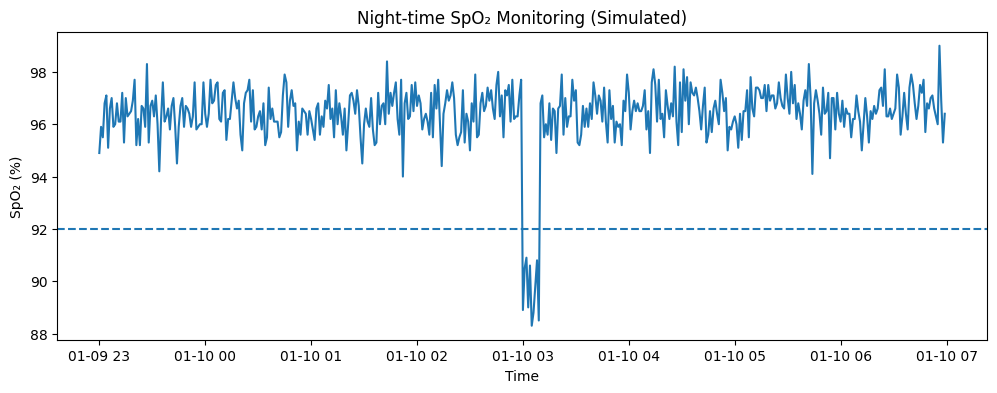

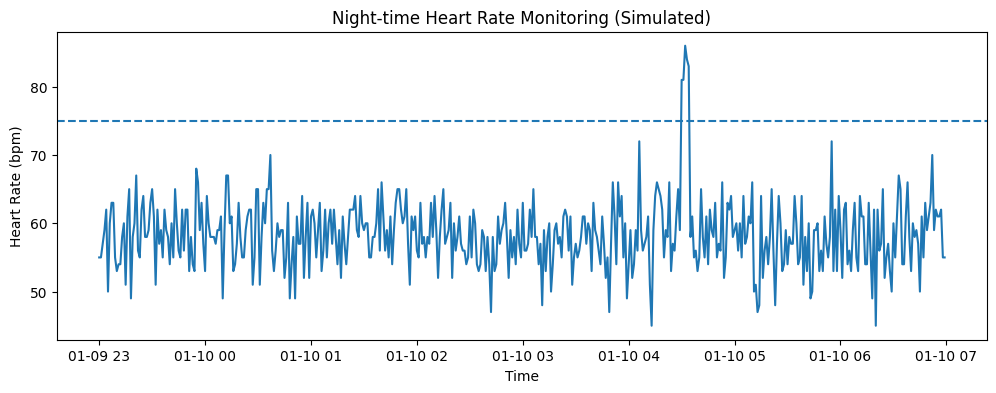

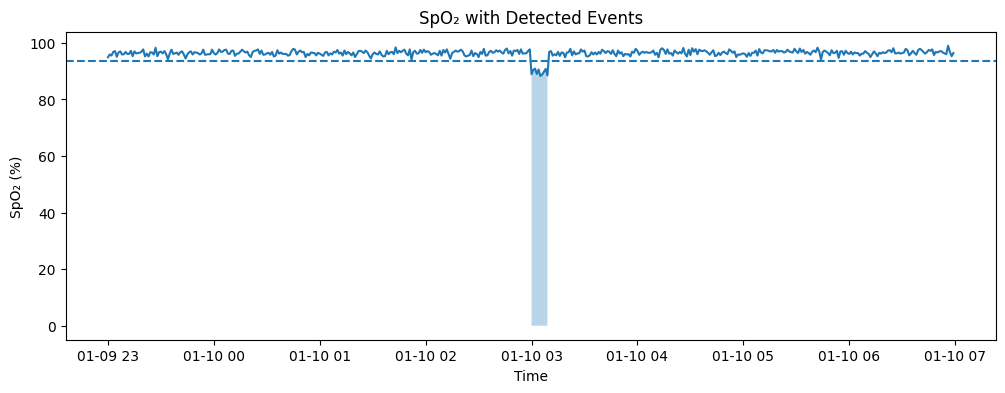

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Morning Report (Night Monitoring Summary) 
Period: 2026-01-09 23:00:00  →  2026-01-10 06:59:00  (480 minutes)

 Key Metrics 
SpO₂: mean 96.4%, min 88.3%, p5 95.0%
Time below warning threshold (93.5152688172043%): 10 minutes
HR: mean 58.4 bpm, min 45 bpm, max 86 bpm

 Events 
Warnings: 2 | Critical: 0
Top events preview:
- SpO2_desaturation (warning): 2026-01-10 03:00:00 – 2026-01-10 03:09:00 (10 min)
- HR_elevation (warning): 2026-01-10 04:30:00 – 2026-01-10 04:34:00 (5 min)

 Notes (Non-clinical) 
- Multiple low SpO₂ segments were detected. Consider checking device fit and sleep position.
- Elevated heart rate segments were observed. Review trends and consider potential triggers (stress, temperature, discomfort).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

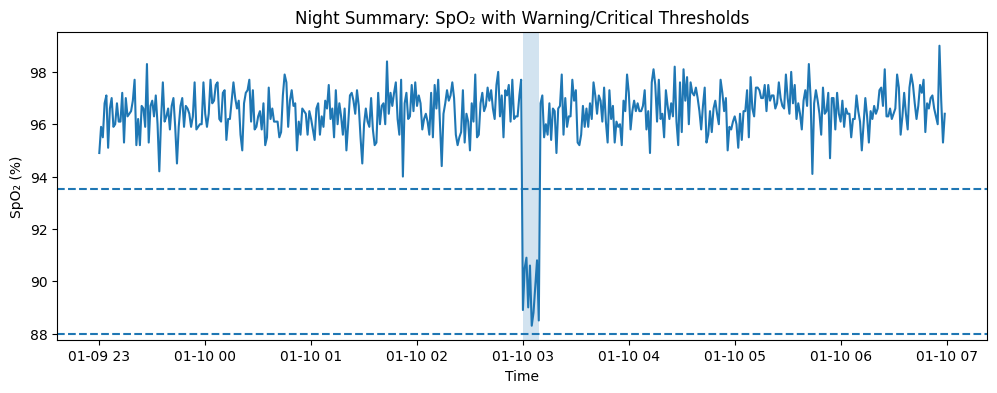

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Night scenario settings
minutes = 8 * 60  # 8 hours
start_time = "2026-01-09 23:00"
time_index = pd.date_range(start=start_time, periods=minutes, freq="min")

#Baseline (typical night) distributions
spo2 = np.random.normal(loc=96.5, scale=0.8, size=minutes)   # SpO2 typical at night
hr   = np.random.normal(loc=58.0, scale=4.5, size=minutes)   # HR typical at night

# Clamp to realistic ranges
spo2 = np.clip(spo2, 92, 99)
hr   = np.clip(hr,   45, 75)

# Add abnormal events for testing
# Desaturation event: 03:00–03:10 (10 minutes)
spo2[240:250] = np.random.uniform(88.0, 91.0, size=10)

# HR spike: 04:30–04:35 (5 minutes)
hr[330:335] = np.random.uniform(80, 90, size=5)

df = pd.DataFrame({
    "timestamp": time_index,
    "SpO2": np.round(spo2, 1),
    "HeartRate": np.round(hr).astype(int)
})

df.head()
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["SpO2"])
plt.axhline(92, linestyle="--")
plt.title("Night-time SpO₂ Monitoring (Simulated)")
plt.ylabel("SpO₂ (%)")
plt.xlabel("Time")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["HeartRate"])
plt.axhline(75, linestyle="--")
plt.title("Night-time Heart Rate Monitoring (Simulated)")
plt.ylabel("Heart Rate (bpm)")
plt.xlabel("Time")
plt.show()
# Filter out obvious abnormal values to estimate "normal night baseline"
baseline_df = df[(df["SpO2"] >= 92) & (df["HeartRate"] <= 75)]

baseline = {
    "SpO2_mean": float(baseline_df["SpO2"].mean()),
    "SpO2_std":  float(baseline_df["SpO2"].std()),
    "HR_mean":   float(baseline_df["HeartRate"].mean()),
    "HR_std":    float(baseline_df["HeartRate"].std()),
}

# Define personalized thresholds (simple, explainable)
# You can tune these later in the text as "design parameters"
thresholds = {
    "SpO2_warning": max(90.0, baseline["SpO2_mean"] - 3.0),  # e.g., baseline-3%
    "SpO2_critical": 88.0,
    "HR_warning": min(95.0, baseline["HR_mean"] + 20.0),
    "HR_critical": 100.0
}

baseline, thresholds
# Current state = last measurement (you can also use "latest reliable measurement")
current = df.iloc[-1].to_dict()

digital_twin = {
    "user_id": "001",
    "mode": "night_monitoring",
    "baseline": {
        "SpO2_mean": round(baseline["SpO2_mean"], 2),
        "SpO2_std": round(baseline["SpO2_std"], 2),
        "HR_mean": round(baseline["HR_mean"], 2),
        "HR_std": round(baseline["HR_std"], 2),
    },
    "thresholds": thresholds,
    "current_state": {
        "timestamp": str(current["timestamp"]),
        "SpO2": float(current["SpO2"]),
        "HeartRate": int(current["HeartRate"]),
    }
}

digital_twin
def detect_events(df: pd.DataFrame, thresholds: dict, min_duration_min: int = 2) -> pd.DataFrame:
    out = df.copy()

    out["spo2_low"] = out["SpO2"] < thresholds["SpO2_warning"]
    out["spo2_critical"] = out["SpO2"] < thresholds["SpO2_critical"]

    out["hr_high"] = out["HeartRate"] > thresholds["HR_warning"]
    out["hr_critical"] = out["HeartRate"] > thresholds["HR_critical"]

    # group consecutive True segments to calculate durations
    def segments(mask: pd.Series):
        grp = (mask != mask.shift(1)).cumsum()
        segs = out[mask].groupby(grp).agg(
            start=("timestamp", "min"),
            end=("timestamp", "max"),
            duration_min=("timestamp", "count"),
            min_spo2=("SpO2", "min"),
            max_hr=("HeartRate", "max")
        ).reset_index(drop=True)
        return segs

    spo2_events = segments(out["spo2_low"])
    hr_events = segments(out["hr_high"])

    # filter by duration
    spo2_events = spo2_events[spo2_events["duration_min"] >= min_duration_min].copy()
    hr_events = hr_events[hr_events["duration_min"] >= min_duration_min].copy()

    spo2_events["event_type"] = "SpO2_desaturation"
    hr_events["event_type"] = "HR_elevation"

    events = pd.concat([spo2_events, hr_events], ignore_index=True)

    # severity labeling
    def severity(row):
        if row["event_type"] == "SpO2_desaturation":
            return "critical" if row["min_spo2"] < thresholds["SpO2_critical"] else "warning"
        if row["event_type"] == "HR_elevation":
            return "critical" if row["max_hr"] > thresholds["HR_critical"] else "warning"
        return "info"

    events["severity"] = events.apply(severity, axis=1)
    events = events.sort_values("start").reset_index(drop=True)
    return events

events = detect_events(df, thresholds, min_duration_min=2)
events
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["SpO2"])
plt.axhline(thresholds["SpO2_warning"], linestyle="--")
plt.title("SpO₂ with Detected Events")
plt.ylabel("SpO₂ (%)")
plt.xlabel("Time")

# Highlight desaturation segments
mask = df["SpO2"] < thresholds["SpO2_warning"]
plt.fill_between(df["timestamp"], df["SpO2"], where=mask, alpha=0.3)

plt.show()
df.to_csv("night_wearable_data.csv", index=False)
events.to_csv("detected_events.csv", index=False)

from google.colab import files
files.download("night_wearable_data.csv")
files.download("detected_events.csv")
# Emergency contacts (example)
contacts = [
    {"name": "Patient", "role": "self", "channel": "app", "address": "in-app"},
    {"name": "Emergency Contact 1", "role": "family", "channel": "sms", "address": "+7XXXXXXXXXX"},
    {"name": "Emergency Contact 2", "role": "family", "channel": "sms", "address": "+7XXXXXXXXXX"},
]

# Notification policy (simple + explainable)
notify_policy = {
    "warning": ["self"],               # warning -> only patient (in-app)
    "critical": ["self", "family"],    # critical -> patient + emergency contacts
}

cooldown_minutes = 15  # anti-spam
notification_log = []  # store sent notifications


def format_alert_message(event_row: pd.Series) -> str:
    etype = event_row["event_type"]
    severity = event_row["severity"]
    start = event_row["start"]
    end = event_row["end"]
    dur = int(event_row["duration_min"])

    if etype == "SpO2_desaturation":
        min_spo2 = float(event_row["min_spo2"])
        return (
            f"[{severity.upper()}] Night monitoring alert: SpO₂ desaturation detected.\n"
            f"Time: {start} – {end} (duration: {dur} min)\n"
            f"Minimum SpO₂: {min_spo2:.1f}%\n"
            f"Recommendation (non-clinical): Re-check device fit / ensure stable position."
        )

    if etype == "HR_elevation":
        max_hr = int(event_row["max_hr"])
        return (
            f"[{severity.upper()}] Night monitoring alert: Elevated heart rate detected.\n"
            f"Time: {start} – {end} (duration: {dur} min)\n"
            f"Maximum HR: {max_hr} bpm\n"
            f"Recommendation (non-clinical): Rest and re-check. If persistent, seek medical advice."
        )

    return f"[{severity.upper()}] Night monitoring alert: event detected.\nTime: {start} – {end}."


def can_send(event_row: pd.Series, recipient_role: str, cooldown_min: int = 15) -> bool:
    """Prevent repeated alerts for same event type + recipient role within cooldown window."""
    if not notification_log:
        return True

    etype = event_row["event_type"]
    t = pd.to_datetime(event_row["start"])

    for item in reversed(notification_log):
        if item["event_type"] == etype and item["recipient_role"] == recipient_role:
            last_time = pd.to_datetime(item["event_start"])
            delta = (t - last_time).total_seconds() / 60.0
            return delta >= cooldown_min

    return True


def send_stub(channel: str, address: str, message: str) -> str:
    """
    Stub sender. In real system: SMS gateway / push notifications / email.
    Here: return 'SENT' and keep evidence for diploma.
    """
    # For demo you can uncomment printing:
    # print(f"\n--- SEND via {channel} to {address} ---\n{message}\n")
    return "SENT"


def notify_for_event(event_row: pd.Series, contacts: list, policy: dict, cooldown_min: int = 15):
    severity = event_row["severity"]
    allowed_roles = policy.get(severity, ["self"])
    message = format_alert_message(event_row)

    for c in contacts:
        if c["role"] not in allowed_roles:
            continue

        if not can_send(event_row, c["role"], cooldown_min=cooldown_min):
            status = "SKIPPED (cooldown)"
        else:
            status = send_stub(c["channel"], c["address"], message)

        notification_log.append({
            "sent_time": str(pd.Timestamp.now()),
            "event_start": str(event_row["start"]),
            "event_end": str(event_row["end"]),
            "event_type": event_row["event_type"],
            "severity": severity,
            "recipient_name": c["name"],
            "recipient_role": c["role"],
            "channel": c["channel"],
            "address": c["address"],
            "status": status
        })


# Run notification workflow
for _, row in events.iterrows():
    notify_for_event(row, contacts, notify_policy, cooldown_min=cooldown_minutes)

notif_df = pd.DataFrame(notification_log)
notif_df
notif_df.to_csv("/content/notification_log.csv", index=False)
from google.colab import files
files.download("/content/notification_log.csv")
def morning_report(df: pd.DataFrame, events: pd.DataFrame, baseline: dict, thresholds: dict) -> dict:
    # Basic stats
    total_minutes = len(df)
    start = df["timestamp"].min()
    end = df["timestamp"].max()

    spo2_min = float(df["SpO2"].min())
    spo2_mean = float(df["SpO2"].mean())
    spo2_p5 = float(np.percentile(df["SpO2"], 5))   # 5th percentile
    spo2_time_below_92 = int((df["SpO2"] < thresholds["SpO2_warning"]).sum())

    hr_min = int(df["HeartRate"].min())
    hr_mean = float(df["HeartRate"].mean())
    hr_max = int(df["HeartRate"].max())

    # Event summary
    if events is None or len(events) == 0:
        event_counts = {"warning": 0, "critical": 0}
        top_events = []
    else:
        event_counts = events["severity"].value_counts().to_dict()
        event_counts = {"warning": int(event_counts.get("warning", 0)),
                        "critical": int(event_counts.get("critical", 0))}
        top_events = events.head(5).to_dict(orient="records")

    # Simple interpretation (non-clinical)
    notes = []
    if spo2_time_below_92 >= 10 or event_counts["critical"] > 0:
        notes.append("Multiple low SpO₂ segments were detected. Consider checking device fit and sleep position.")
    if hr_max > thresholds["HR_warning"]:
        notes.append("Elevated heart rate segments were observed. Review trends and consider potential triggers (stress, temperature, discomfort).")
    if not notes:
        notes.append("No significant abnormal patterns detected. Continue nightly monitoring for trend analysis.")

    report = {
        "period": {"start": str(start), "end": str(end), "duration_minutes": int(total_minutes)},
        "baseline_used": {
            "SpO2_mean": round(baseline["SpO2_mean"], 2),
            "SpO2_std": round(baseline["SpO2_std"], 2),
            "HR_mean": round(baseline["HR_mean"], 2),
            "HR_std": round(baseline["HR_std"], 2),
            "SpO2_warning_threshold": thresholds["SpO2_warning"],
            "SpO2_critical_threshold": thresholds["SpO2_critical"],
            "HR_warning_threshold": thresholds["HR_warning"],
            "HR_critical_threshold": thresholds["HR_critical"]
        },
        "summary_metrics": {
            "SpO2_min": round(spo2_min, 1),
            "SpO2_mean": round(spo2_mean, 1),
            "SpO2_5th_percentile": round(spo2_p5, 1),
            "minutes_SpO2_below_warning": spo2_time_below_92,
            "HR_min": hr_min,
            "HR_mean": round(hr_mean, 1),
            "HR_max": hr_max
        },
        "events": {
            "counts": event_counts,
            "top_events_preview": top_events
        },
        "non_clinical_notes": notes
    }
    return report

report = morning_report(df, events, baseline, thresholds)

import json
import pandas as pd
import numpy as np

def make_json_safe(obj):
    if isinstance(obj, pd.Timestamp):
        return obj.isoformat()
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    return obj

safe_report = make_json_safe(report)

with open("/content/morning_report.json", "w", encoding="utf-8") as f:
    json.dump(safe_report, f, ensure_ascii=False, indent=2)

from google.colab import files
files.download("/content/morning_report.json")
def print_morning_report(report: dict):
    p = report["period"]
    b = report["baseline_used"]
    m = report["summary_metrics"]
    e = report["events"]
    notes = report["non_clinical_notes"]

    print(" Morning Report (Night Monitoring Summary) ")
    print(f"Period: {p['start']}  →  {p['end']}  ({p['duration_minutes']} minutes)")
    print("\n Key Metrics ")
    print(f"SpO₂: mean {m['SpO2_mean']}%, min {m['SpO2_min']}%, p5 {m['SpO2_5th_percentile']}%")
    print(f"Time below warning threshold ({b['SpO2_warning_threshold']}%): {m['minutes_SpO2_below_warning']} minutes")
    print(f"HR: mean {m['HR_mean']} bpm, min {m['HR_min']} bpm, max {m['HR_max']} bpm")

    print("\n Events ")
    print(f"Warnings: {e['counts']['warning']} | Critical: {e['counts']['critical']}")
    if len(e["top_events_preview"]) > 0:
        print("Top events preview:")
        for ev in e["top_events_preview"]:
            print(f"- {ev['event_type']} ({ev['severity']}): {ev['start']} – {ev['end']} ({int(ev['duration_min'])} min)")
    else:
        print("No events detected.")

    print("\n Notes (Non-clinical) ")
    for n in notes:
        print(f"- {n}")

print_morning_report(report)
import json

# Save JSON report
#with open("morning_report.json", "w", encoding="utf-8") as f:
    #json.dump(report, f, ensure_ascii=False, indent=2)

# Save a compact CSV summary (1 row) — удобно вставлять как таблицу в диплом
summary_row = {
    "start": report["period"]["start"],
    "end": report["period"]["end"],
    "duration_minutes": report["period"]["duration_minutes"],
    "SpO2_mean": report["summary_metrics"]["SpO2_mean"],
    "SpO2_min": report["summary_metrics"]["SpO2_min"],
    "SpO2_p5": report["summary_metrics"]["SpO2_5th_percentile"],
    "minutes_SpO2_below_warning": report["summary_metrics"]["minutes_SpO2_below_warning"],
    "HR_mean": report["summary_metrics"]["HR_mean"],
    "HR_min": report["summary_metrics"]["HR_min"],
    "HR_max": report["summary_metrics"]["HR_max"],
    "warnings": report["events"]["counts"]["warning"],
    "critical": report["events"]["counts"]["critical"]
}
pd.DataFrame([summary_row]).to_csv("morning_report_summary.csv", index=False)

from google.colab import files
files.download("morning_report.json")
files.download("morning_report_summary.csv")
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["SpO2"])
plt.axhline(thresholds["SpO2_warning"], linestyle="--")
plt.axhline(thresholds["SpO2_critical"], linestyle="--")
plt.title("Night Summary: SpO₂ with Warning/Critical Thresholds")
plt.ylabel("SpO₂ (%)")
plt.xlabel("Time")

# Mark events on plot
if len(events) > 0:
    for _, ev in events[events["event_type"] == "SpO2_desaturation"].iterrows():
        plt.axvspan(pd.to_datetime(ev["start"]), pd.to_datetime(ev["end"]), alpha=0.2)

plt.show()
def make_json_safe(obj):
    """Recursively convert pandas Timestamp and numpy types to JSON-safe types."""
    if isinstance(obj, pd.Timestamp):
        return obj.isoformat()
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    return obj
    safe_report = make_json_safe(report)

import json

with open("/content/morning_report.json", "w", encoding="utf-8") as f:
    json.dump(safe_report, f, ensure_ascii=False, indent=2)

from google.colab import files
files.download("/content/morning_report.json")